In [ ]:
import os 
os.chdir("..")
from src.cpwc_v.multires.class_multiressolver import *
import matplotlib.pyplot as plt
import torch
from src.cpwc_v.tools.ptychography import Ptychography as Ptychography
from src.cpwc_v.tools.utils import *
torch.cuda.empty_cache()

# Set seeds 
torch.manual_seed(0)
np.random.seed(0)
import gc
for obj in gc.get_objects():
    try:
        if torch.is_tensor(obj) and obj.is_cuda:
            print(type(obj), obj.size())
    except Exception:
        pass

cycle = [0, -1, -1, -1,  1, 1, 1]
lmbda = 0
tol = [1e-10] * 9
tol_in = [1e-10] * 9
device = 'cuda'
max_scale = 9
max_probe_size = 128
image = np.load("test_data/potential.npy")
image = (image - image.min())/(image.max() - image.min()) 
image_tensor = torch.tensor(image).double().to(device).view(1, 1, 2**max_scale, 2**max_scale)
image_tensor_ = torch.exp(1j * image_tensor)
multires = MultiRes(max_scale, device)


def extract_data(nested_list):
    result = []
    for item in nested_list:
        if isinstance(item, list):  # If the item is a list, recurse into it
            result.extend(extract_data(item))
        else:  # If the item is not a list, add it to the result
            result.append(item)
    return result

def unwrap_2d(phase):
    """
    Unwraps a 2D phase array using NumPy's 1D unwrap function.
    
    Parameters:
    phase (numpy array): The 2D phase array to be unwrapped.
    
    Returns:
    unwrapped_phase (numpy array): The 2D unwrapped phase array.
    """
    # Unwrap along the first axis (rows)
    unwrapped_phase = np.unwrap(phase, axis=0)
    
    # Unwrap along the second axis (columns)
    unwrapped_phase = np.unwrap(unwrapped_phase, axis=1)
    
    return unwrapped_phase

def save_data(model,model_name,image):
    image = image[::,::]
    mean_img = np.mean(image)
    loss_data = extract_data(model.measures["loss"])
    cos_sim = extract_data(model.measures["csim"])
    phase = torch.angle(model.c_k[0,0,:,:].to('cpu'))
    phase = phase.numpy()
    phase = unwrap_2d(phase)
    phase += (mean_img-np.mean(phase)) 

    np.save("np_data/{}_overlap_loss.npy".format(model_name), loss_data)
    np.save("np_data/{}_overlap_csim.npy".format(model_name), cos_sim)
    np.save("np_data/{}_overlap_image.npy".format(model_name), phase)

/home/efe/Desktop/Multiresolution-Framework-for-Fourier-Ptychography/.venv/lib/python3.8/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm
/home/efe/Desktop/Multiresolution-Framework-for-Fourier-Ptychography/.venv/lib/python3.8/site-packages/torch/distributed/distributed_c10d.py:181: UserWarning: torch.distributed.reduce_op is deprecated, please use torch.distributed.ReduceOp instead
  warnings.warn(


In [2]:
import random
seed_list = [i*10 for i in range(1,10)]
def set_seed(seed):
    random.seed(seed)
    np.random.seed(seed)
    torch.manual_seed(seed)
    if torch.cuda.is_available():
        torch.cuda.manual_seed_all(seed)
a = os.chdir("./dat")

In [3]:
import torch
import numpy as np
import os

checkpoint_dir = "gd/checkpoints75"
os.makedirs(checkpoint_dir, exist_ok=True)
seed = 60
set_seed(seed)

# Initialize probe and operator
probe = Ptychography(image_tensor_, max_probe_size, max_probe_size, 1, device)
LR = 1e-3
max_shift = 32
I_in = 15 * np.array([1, 15, 10, 5, 10, 30, 100])
I_out = 10 * np.array([0, 0, 0, 0, 0, 0, 350])
linOperator = Ptychography(max_scale=max_scale, max_probe_size=max_probe_size, max_shift=max_shift, device=device)
image_tensor_ = linOperator.apply(image_tensor_)

# Define loss function
loss = Loss(linOperator, image_tensor_)

# Initialize solver
model = MultiResSolver(multires, loss, LR=LR, I_in=I_in, I_out=I_out, tol=tol, tol_in=tol_in, cycle=cycle, l1_type="l1_row",gt=image)

# Solve
model.solve_multigrid()
model.print_time()

image = image[::,::]
mean_img = np.mean(image)
loss_data = extract_data(model.measures["loss"])
cos_sim = extract_data(model.measures["csim"])
phase = torch.angle(model.c_k[0,0,:,:].to('cpu'))
phase = phase.numpy()
phase = unwrap_2d(phase)
phase += (mean_img-np.mean(phase)) 
# Extract and store new loss values
# Save checkpoint and loss values
np.save(checkpoint_dir+"/overlap_loss_{}.npy".format(seed), loss_data)
np.save(checkpoint_dir+"/overlap_csim_{}.npy".format(seed), cos_sim)
np.save(checkpoint_dir+"/overlap_image_{}.npy".format(seed), phase)


----------- s = 9 -----------
----------- s = 8 -----------
----------- s = 7 -----------
----------- s = 6 -----------
----------- s = 7 -----------
----------- s = 8 -----------
----------- s = 9 -----------
Iter 1, [loss, mse, reg, rel_loss, LR] : [129090.7067486, 129090.7067486, 0.0008938, 0.001] 
Iter 2, [loss, mse, reg, rel_loss, LR] : [128975.328603, 128975.328603, 0.0009542, 0.001] 
Iter 3, [loss, mse, reg, rel_loss, LR] : [128852.25951, 128852.25951, 0.0012816, 0.001] 
Iter 4, [loss, mse, reg, rel_loss, LR] : [128687.1190143, 128687.1190143, 0.0016296, 0.001] 
Iter 5, [loss, mse, reg, rel_loss, LR] : [128477.4070003, 128477.4070003, 0.0019942, 0.001] 
Iter 6, [loss, mse, reg, rel_loss, LR] : [128221.1981507, 128221.1981507, 0.0023755, 0.001] 
Iter 7, [loss, mse, reg, rel_loss, LR] : [127916.6124678, 127916.6124678, 0.0027686, 0.001] 
Iter 8, [loss, mse, reg, rel_loss, LR] : [127562.4687091, 127562.4687091, 0.0031712, 0.001] 
Iter 9, [loss, mse, reg, rel_loss, LR] : [127157.943

In [6]:
#Plot the means and variances of the loss

loss1 = np.load("./gd/checkpoints75/overlap_loss_0.npy")
loss2 = np.load("./gd/checkpoints75/overlap_loss_10.npy")
loss3 = np.load("./gd/checkpoints75/overlap_loss_20.npy")
loss4 = np.load("./gd/checkpoints75/overlap_loss_30.npy")
loss5 = np.load("./gd/checkpoints75/overlap_loss_40.npy")
loss6 = np.load("./gd/checkpoints75/overlap_loss_50.npy")
loss7 = np.load("./gd/checkpoints75/overlap_loss_60.npy")

#Find the mean and variance of the 7 different loss values
mean = (loss1 + loss2 + loss3 + loss4 + loss5 + loss6 + loss7)/7
std = np.std(np.array([loss1, loss2, loss3, loss4, loss5, loss6, loss7]), axis=0)

#Save mean and std
np.save("./gd/checkpoints75/mean_loss.npy", mean)
np.save("./gd/checkpoints75/std_loss.npy", std)

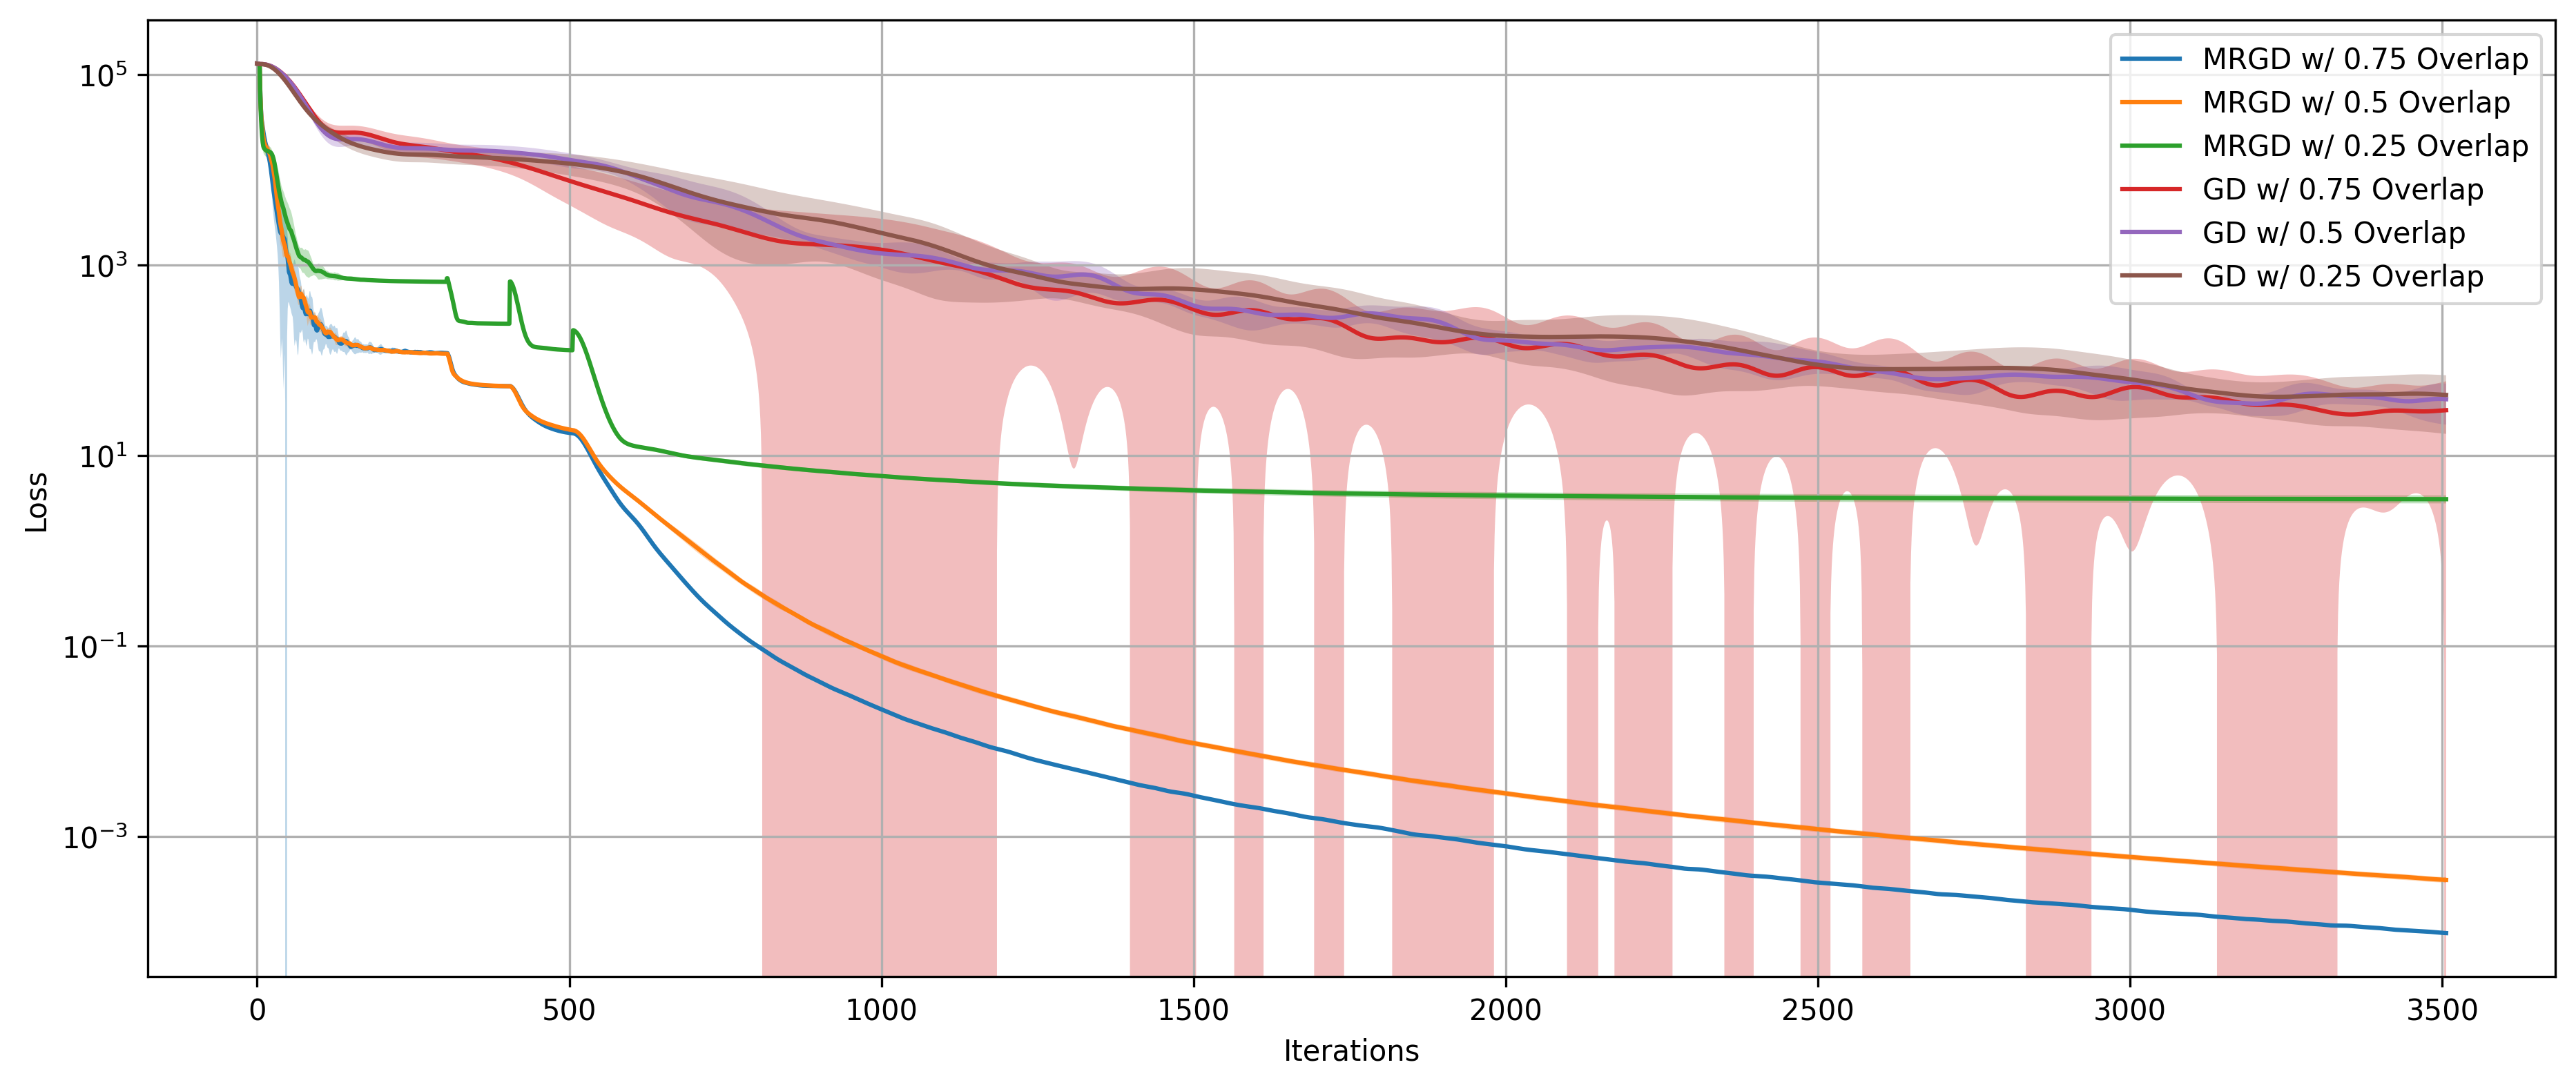

In [8]:
# Plot all

mean75 = np.load("./mrgd/checkpoints75/mean_loss.npy")
std75 = np.load("./mrgd/checkpoints75/std_loss.npy")

mean50 = np.load("./mrgd/checkpoints50/mean_loss.npy")
std50 = np.load("./mrgd/checkpoints50/std_loss.npy")

mean25 = np.load("./mrgd/checkpoints25/mean_loss.npy")
std25 = np.load("./mrgd/checkpoints25/std_loss.npy")

meanu75 = np.load("./gd/checkpoints75/mean_loss.npy")
meanu50 = np.load("./gd/checkpoints50/mean_loss.npy")
meanu25 = np.load("./gd/checkpoints25/mean_loss.npy")

stdu75 = np.load("./gd/checkpoints75/std_loss.npy")
stdu50 = np.load("./gd/checkpoints50/std_loss.npy")
stdu25 = np.load("./gd/checkpoints25/std_loss.npy")



plt.figure(figsize = (15, 6),dpi = 300)
plt.semilogy(mean75, label="MRGD w/ 0.75 Overlap")
plt.fill_between(np.arange(len(mean75)), mean75-std75, mean75+std75, alpha=0.3)
plt.semilogy(mean50, label="MRGD w/ 0.5 Overlap")
plt.fill_between(np.arange(len(mean50)), mean50-std50, mean50+std50, alpha=0.3)
plt.semilogy(mean25, label="MRGD w/ 0.25 Overlap")
plt.fill_between(np.arange(len(mean25)), mean25-std25, mean25+std25, alpha=0.3)
plt.semilogy(meanu75, label="GD w/ 0.75 Overlap")
plt.fill_between(np.arange(len(meanu75)), meanu75-stdu75, meanu75+stdu75, alpha=0.3)
plt.semilogy(meanu50, label="GD w/ 0.5 Overlap")
plt.fill_between(np.arange(len(meanu50)), meanu50-stdu50, meanu50+stdu50, alpha=0.3)
plt.semilogy(meanu25, label="GD w/ 0.25 Overlap")
plt.fill_between(np.arange(len(meanu25)), meanu25-stdu25, meanu25+stdu25, alpha=0.3)
plt.xlabel("Iterations")
plt.ylabel("Loss")
plt.legend()
plt.grid()


In [14]:
# Cosine similarity 
folder = "mrgd/checkpoints75"
csim1 = np.load(folder+"/overlap_csim_0.npy")
csim2 = np.load(folder+"/overlap_csim_10.npy")
csim3 = np.load(folder+"/overlap_csim_20.npy")
csim4 = np.load(folder+"/overlap_csim_30.npy")
csim5 = np.load(folder+"/overlap_csim_40.npy")
csim6 = np.load(folder+"/overlap_csim_50.npy")
csim7 = np.load(folder+"/overlap_csim_60.npy")

#Find the mean and variance of the 7 different loss values
mean = (csim1 + csim2 + csim3 + csim4 + csim5 + csim6 + csim7)/7
std = np.std(np.array([csim1, csim2, csim3, csim4, csim5, csim6, csim7]), axis=0)

#Save mean and std
np.save(folder+"/mean_csim.npy", mean)
np.save(folder+"/std_csim.npy", std)


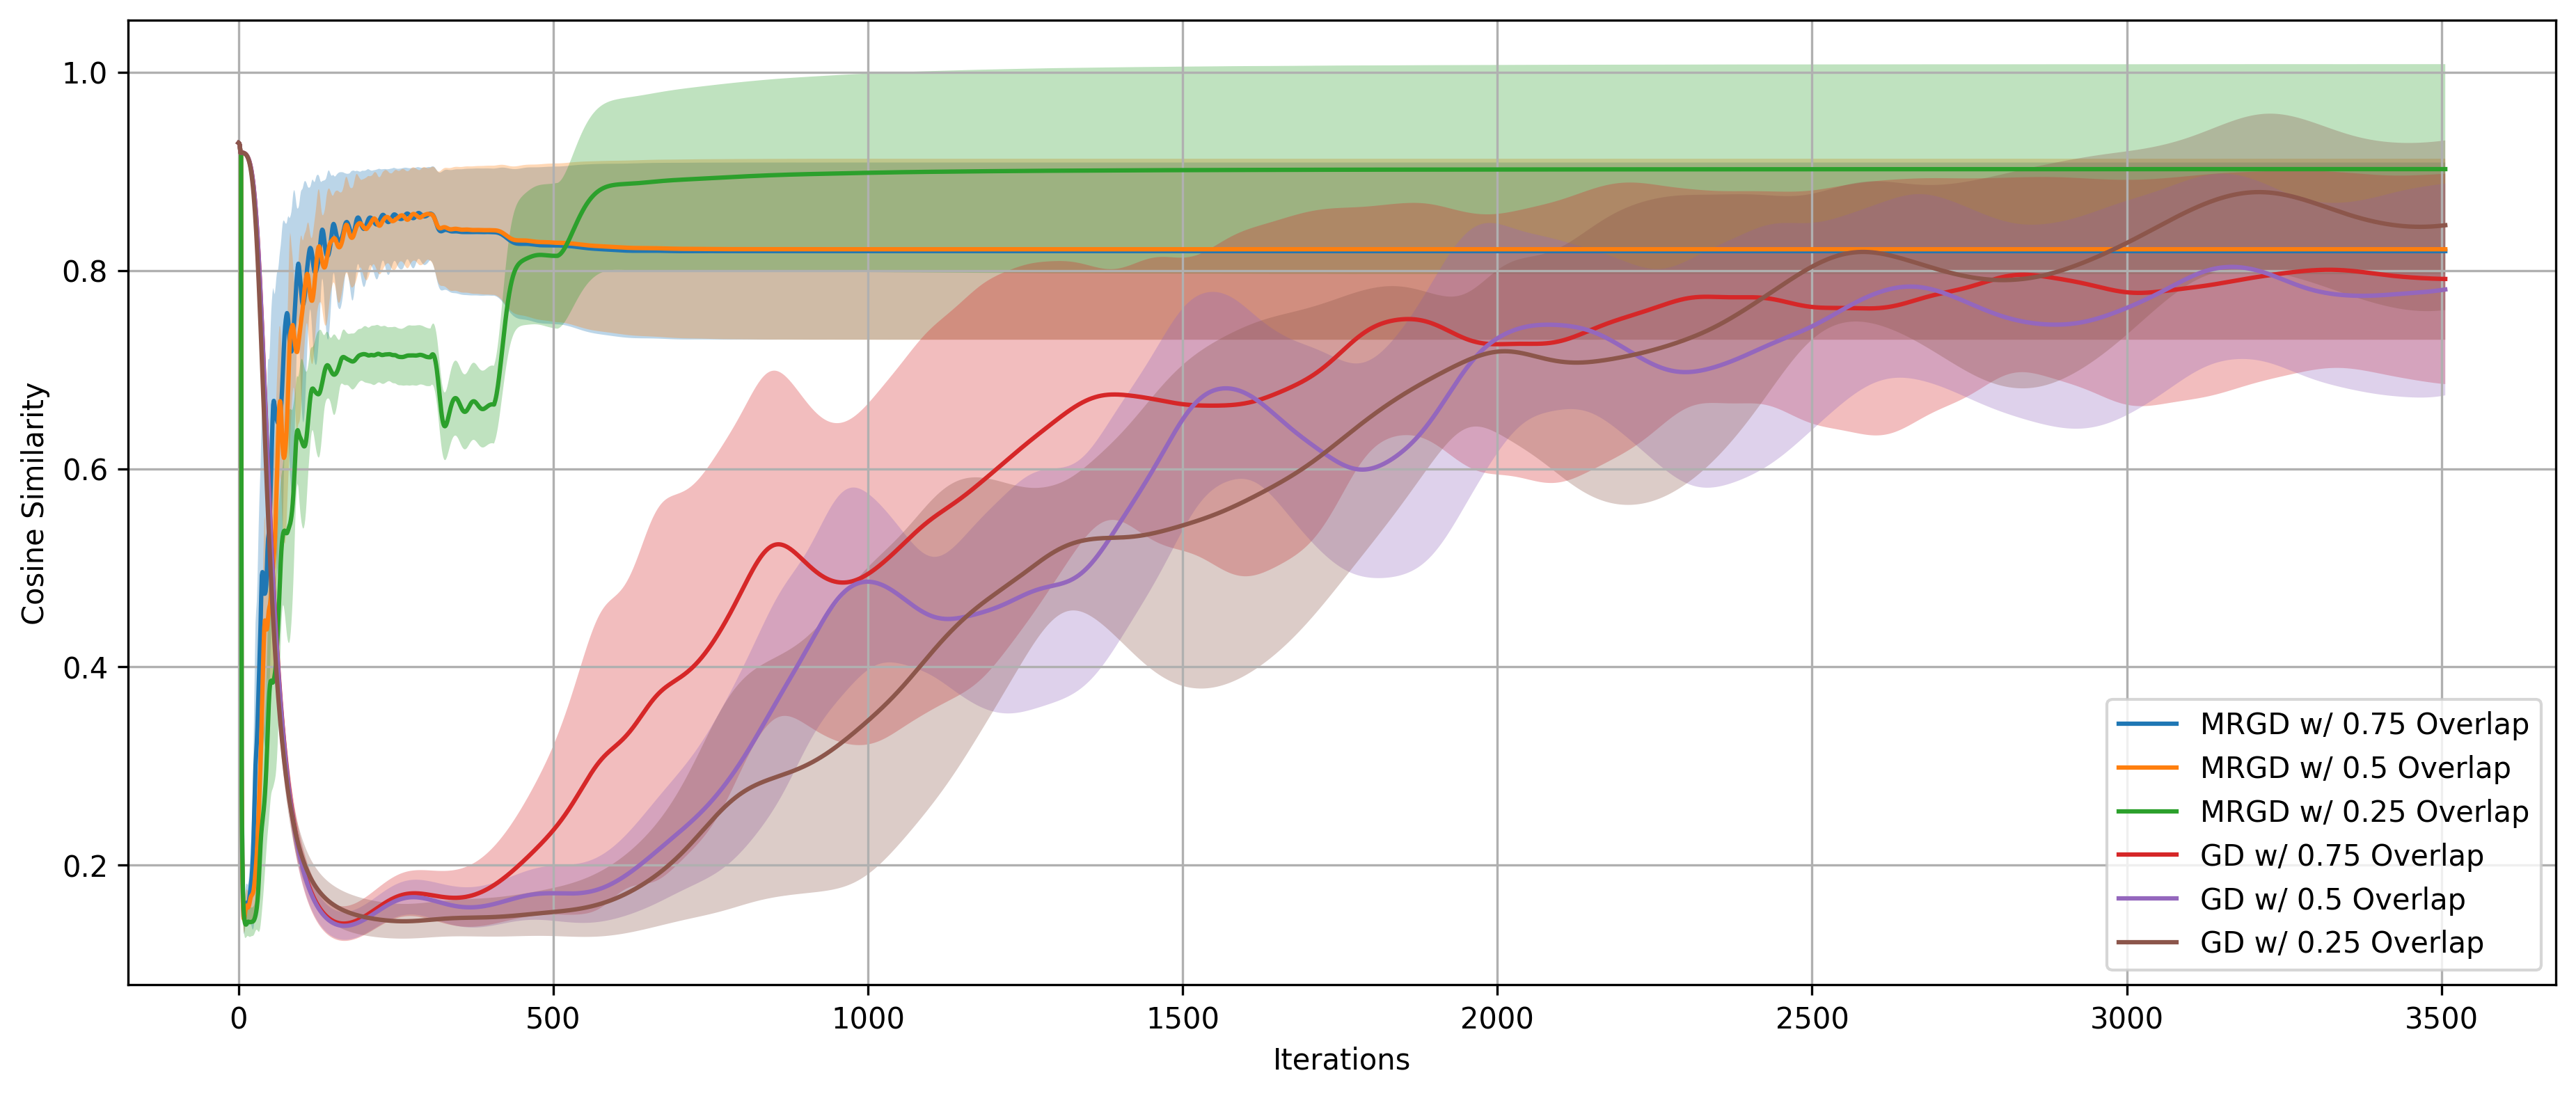

In [15]:
# Plot cosine similarity

mean75 = np.load("./mrgd/checkpoints75/mean_csim.npy")
std75 = np.load("./mrgd/checkpoints75/std_csim.npy")

mean50 = np.load("./mrgd/checkpoints50/mean_csim.npy")
std50 = np.load("./mrgd/checkpoints50/std_csim.npy")

mean25 = np.load("./mrgd/checkpoints25/mean_csim.npy")
std25 = np.load("./mrgd/checkpoints25/std_csim.npy")

meanu75 = np.load("./gd/checkpoints75/mean_csim.npy")
meanu50 = np.load("./gd/checkpoints50/mean_csim.npy")
meanu25 = np.load("./gd/checkpoints25/mean_csim.npy")

stdu75 = np.load("./gd/checkpoints75/std_csim.npy")
stdu50 = np.load("./gd/checkpoints50/std_csim.npy")
stdu25 = np.load("./gd/checkpoints25/std_csim.npy")


plt.figure(figsize = (15, 6),dpi = 300)
plt.plot(mean75, label="MRGD w/ 0.75 Overlap")
plt.fill_between(np.arange(len(mean75)), mean75-std75, mean75+std75, alpha=0.3)
plt.plot(mean50, label="MRGD w/ 0.5 Overlap")
plt.fill_between(np.arange(len(mean50)), mean50-std50, mean50+std50, alpha=0.3)
plt.plot(mean25, label="MRGD w/ 0.25 Overlap")
plt.fill_between(np.arange(len(mean25)), mean25-std25, mean25+std25, alpha=0.3)
plt.plot(meanu75, label="GD w/ 0.75 Overlap")
plt.fill_between(np.arange(len(meanu75)), meanu75-stdu75, meanu75+stdu75, alpha=0.3)
plt.plot(meanu50, label="GD w/ 0.5 Overlap")
plt.fill_between(np.arange(len(meanu50)), meanu50-stdu50, meanu50+stdu50, alpha=0.3)
plt.plot(meanu25, label="GD w/ 0.25 Overlap")
plt.fill_between(np.arange(len(meanu25)), meanu25-stdu25, meanu25+stdu25, alpha=0.3)
plt.xlabel("Iterations")
plt.ylabel("Cosine Similarity")
plt.legend()
plt.grid()
plt.show()
